In [18]:
from __future__ import unicode_literals, print_function, division

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random


In [8]:
device = torch.device("cpu")
from get_cn_en_pairs import get_training_pairs, SOS_token, EOS_token, MAX_LENGTH, output_lang, input_lang

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [11]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden #

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [12]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = get_training_pairs(n_iters)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, True)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        # decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


In [14]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [19]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train_losses = trainIters(encoder1, decoder1, 5000, print_every=5000)


1m 25s (- 0m 0s) (5000 100%) 3.1520


<Figure size 640x480 with 0 Axes>

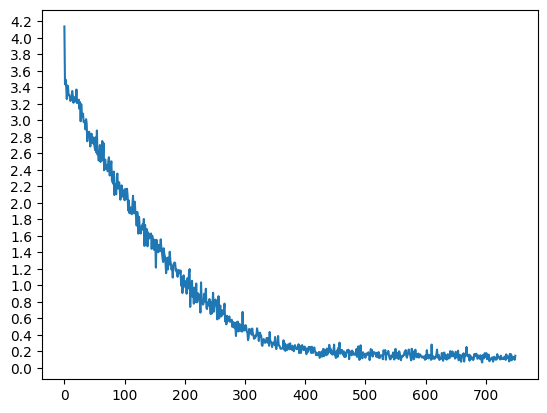

In [16]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

showPlot(train_losses)

In [17]:
evaluateRandomly(encoder1, decoder1)

> 她没像你那样有耐心 。
= she is not as patient as you .
< she is not as patient as you . <EOS>

> 我们不年轻 。
= we re not young .
< we aren t young . <EOS>

> 她擅长打网球 。
= she is good at playing tennis .
< she is good at tennis . <EOS>

> 您可以走了 。
= you re free to go .
< you are free to go . <EOS>

> 我正等著这家店开门 。
= i am waiting for the store to open .
< i m waiting for this store to open . <EOS>

> 明天他们将离开日本 。
= they are leaving japan tomorrow .
< they are leaving japan tomorrow . <EOS>

> 他准会忘 。
= he s bound to forget .
< he s bound to forget . <EOS>

> 我们是个家庭 。
= we re a family .
< we re a family . <EOS>

> 她已经五天不上学了 。
= she s been absent from school for five days .
< she s been absent from school for five days . <EOS>

> 我们明天要离开 。
= we are going to leave tomorrow .
< we are going to leave tomorrow . <EOS>



In [18]:
output_words = evaluate(encoder1, decoder1, '我是自由')
output_sentence = ' '.join(output_words)
print(output_sentence)

i m free . <EOS>
